<a href="https://colab.research.google.com/github/siddharth-69/Earth-quake-prediction/blob/master/Earthquake_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install kaggle
!pip install numpy==1.15.0
!pip install catboost


In [0]:
import pandas as pd
import numpy as np 
from catboost import CatBoostRegressor,Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR,SVR
import matplotlib.pyplot as plt

In [11]:
from google.colab import files

uploaded=files.upload()


#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [12]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2617           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge       9981           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4134            True  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         33            True  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2294           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2897           False  
LANL-Ear

In [14]:
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 53.9MB/s]
 95% 229M/242M [00:05<00:00, 73.3MB/s]
100% 242M/242M [00:05<00:00, 47.1MB/s]
100% 2.02G/2.03G [00:46<00:00, 74.7MB/s]
100% 2.03G/2.03G [00:46<00:00, 46.8MB/s]


In [15]:
!ls

sample_data  sample_submission.csv  test.zip  train.csv.zip


In [16]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
df=pd.read_csv('train.csv',nrows=6000000,dtype={'acoustic_data':np.int64,'time_to_failure':np.float64})

In [19]:
df.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [0]:
#store_first_100_points_of_the_data
train_ad_sample=df['acoustic_data'][0::100]
train_ttf_sample=df['time_to_failure'][0::100]

In [30]:
print(train_ad_sample)

0          12
100        -1
200         7
300        -4
400         9
500         0
600         7
700         4
800        11
900        11
1000        6
1100       12
1200        9
1300        3
1400       -3
1500        5
1600       11
1700       12
1800        3
1900        1
2000        3
2100        6
2200        6
2300        5
2400        2
2500       12
2600      -92
2700      -12
2800       44
2900       25
           ..
5997000     7
5997100     6
5997200     3
5997300    13
5997400    11
5997500     2
5997600    -7
5997700     7
5997800     1
5997900     4
5998000     0
5998100     6
5998200     1
5998300     5
5998400     7
5998500     2
5998600     3
5998700     4
5998800     3
5998900     6
5999000     4
5999100     0
5999200     4
5999300     6
5999400     5
5999500     6
5999600     6
5999700     5
5999800     5
5999900     1
Name: acoustic_data, Length: 60000, dtype: int64


In [31]:
print(train_ttf_sample)

0           1.469100
100         1.469100
200         1.469100
300         1.469100
400         1.469100
500         1.469099
600         1.469099
700         1.469099
800         1.469099
900         1.469099
1000        1.469099
1100        1.469099
1200        1.469099
1300        1.469099
1400        1.469098
1500        1.469098
1600        1.469098
1700        1.469098
1800        1.469098
1900        1.469098
2000        1.469098
2100        1.469098
2200        1.469098
2300        1.469097
2400        1.469097
2500        1.469097
2600        1.469097
2700        1.469097
2800        1.469097
2900        1.469097
             ...    
5997000    11.452499
5997100    11.452499
5997200    11.452499
5997300    11.452499
5997400    11.452499
5997500    11.452499
5997600    11.452499
5997700    11.452499
5997800    11.452499
5997900    11.452498
5998000    11.452498
5998100    11.452498
5998200    11.452498
5998300    11.452498
5998400    11.452498
5998500    11.452498
5998600    11

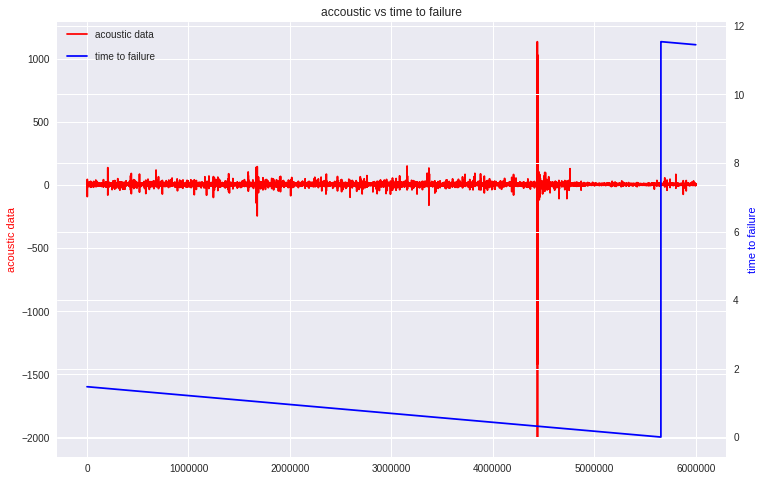

In [32]:
def plot_func(train_ad_sample,train_ttf_sample,title='accoustic vs time to failure'):
  fig,ax1=plt.subplots(figsize=(12,8))
  plt.title(title)
  plt.plot(train_ad_sample,color='r')
  ax1.set_ylabel('acoustic data', color='r')
  plt.legend(['acoustic data'], loc=(0.01, 0.95))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample, color='b')
  ax2.set_ylabel('time to failure', color='b')
  plt.legend(['time to failure'], loc=(0.01, 0.9))
  plt.grid(True)
  
plot_func(train_ad_sample, train_ttf_sample)
del train_ad_sample
del train_ttf_sample
  

# Feature Engineering

In [39]:
!pip install numpy==1.16.0

    100% |████████████████████████████████| 17.3MB 1.5MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.1 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.15.0
    Uninstalling numpy-1.15.0:
      Successfully uninstalled numpy-1.15.0


In [0]:
import numpy as np

In [0]:


#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(X.quantile(0.01))
    strain.append(X.quantile(0.05))
    strain.append(X.quantile(0.95))
    strain.append(X.quantile(0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
X_train.describe()

In [46]:
train_pool=Pool(X_train,y_train)
model=CatBoostRegressor(iterations=10000,loss_function='MAE',boosting_type='Ordered')
model.fit(X_train,y_train,silent=True)
print(model.best_score_)

{'learn': {'MAE': 1.7804224713035586}}


In [47]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}
